# 폴더 경로 정의하기

In [ ]:
import os

data_dir = '/content/drive/MyDrive/Colab Notebooks/Github/IndividualProjcet-lofiToHifi/MyData'

grayscaled_dir = data_dir + '/grayscaled'
grayscaled_hifi_dir = grayscaled_dir + '/fake-hifi'
grayscaled_lofi_dir = grayscaled_dir + '/lofi'

sketched_dir = data_dir + '/sketched'
sketched_hifi_dir = sketched_dir + '/fake-hifi'
sketched_lofi_dir = sketched_dir + '/lofi'

real_hifi_dir = data_dir + '/real-hifi'
weight_dir = data_dir + '/weight'

grayscaled_model_gen_weight_file = weight_dir + '/grayscaled_model_gen.pt'
grayscaled_model_dis_weight_file = weight_dir + '/grayscaled_model_dis.pt'
sketched_model_gen_weight_file = weight_dir + '/sketched_model_gen.pt'
sketched_model_dis_weight_file = weight_dir + '/sketched_model_dis.pt'


# 자료 저장할 폴더 만들기
def create_dir(name):
    if not os.path.isdir(name):
        os.makedirs(name)

create_dir(grayscaled_dir)
create_dir(grayscaled_hifi_dir)
create_dir(grayscaled_lofi_dir)

create_dir(sketched_dir)
create_dir(sketched_hifi_dir)
create_dir(sketched_lofi_dir)

create_dir(real_hifi_dir)
create_dir(weight_dir)

# 웹 크롤링 및 데이터 저장하기
---
- https://pgh268400.tistory.com/286
- https://velog.io/@jungeun-dev/Python-%EC%9B%B9-%ED%81%AC%EB%A1%A4%EB%A7%81Selenium-%EA%B5%AC%EA%B8%80-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%88%98%EC%A7%91
- https://blog.naver.com/PostView.nhn?blogId=jinyuri303&logNo=222268855640&categoryNo=39&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView
- https://swlock.blogspot.com/2021/10/python-count-files.html

In [ ]:
# 필요한 라이브러리 가져오기

!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import time
import os
import requests
from PIL import Image
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver import ActionChains

In [ ]:
# 특정 키워드로 검색한 구글 이미지들을 저장

def get_images_from_web(keyword, dir_name):

    #Colab에선 웹브라우저 창이 뜨지 않으므로 별도 설정한다.
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome('chromedriver', options=options)
    
    # 구글 이미지 검색창으로 이동
    url = "https://www.google.co.kr/imghp?hl=ko" 
    driver.get(url)

    # 해당 키워드 검색하기
    search_box = driver.find_element(By.NAME, 'q')
    search_box.send_keys(keyword)
    search_box.send_keys(Keys.ENTER)

    # 처음에는 일부 이미지만 보여지기 때문에, 스크롤을 내려서 더 불러오기
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);") 
        time.sleep(1)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            try:
                driver.find_element(By.CSS_SELECTOR, ".mye4qd").click()
            except:
                break
        last_height = new_height

    # 이미지 저장하기
    imgs = driver.find_elements(By.CSS_SELECTOR, ".rg_i.Q4LuWd")
    actions = ActionChains(driver)

    count = 1
    for i, img in enumerate(imgs):
        print("\r" + str(i+1) + "/" + str(len(imgs)), end='  ')
        try:
            actions.move_to_element(img).click().perform()
            time.sleep(2)
            # img_url = driver.find_element(By.CSS_SELECTOR, ".n3VNCb.KAlRDb").get_attribute('src')
            img_url = driver.find_element(By.XPATH, '//*[@id="Sva75c"]/div/div/div[3]/div[2]/c-wiz/div/div[1]/div[1]/div[3]/div/a/img').get_attribute('src')
            file_path = dir_name + '/img' + str(count) + '.jpg'
            req = requests.get(img_url)
            print("count: " + str(count), end = "   ") 
            print(req.content[:20])
            if req.content[:1] == b'<' or req.content[:4] == b'RIFF':
                print('not readable')
                continue
            with open(file_path, 'wb') as outfile:
                outfile.write(req.content)
            count += 1
        except:
            print('fail')
            pass

    driver.close()

In [ ]:
# 라벨로 사용할 앱 디자인 관련 이미지 크롤링하기
get_images_from_web(keyword='app design', dir_name=real_hifi_dir)

1/382  count: 1   b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'
2/382  count: 2   b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x02\x00v\x00v\x00\x00'
3/382  count: 3   b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00'
4/382  count: 4   b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'
5/382  count: 5   b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00'
6/382  count: 6   b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00'
7/382  count: 7   b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x02\x00%\x00%\x00\x00'
8/382  count: 8   b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00'
9/382  count: 9   b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\x00\x00\x00\x00\x00'
10/382  count: 10   b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00'
11/382  count: 11   b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'
12/382  count: 12   b'\xff\xd8\xff\xe0\x00\x10JF

# 흑백으로 바꾼 이미지 저장하기
---
- https://www.delftstack.com/ko/howto/python/convert-image-to-grayscale-python/

In [ ]:
from PIL import Image

In [ ]:
files = os.listdir(real_hifi_dir)
files_cnt = len(files)
for i, filename in enumerate(files):
    print("\r" + str(i+1) + "/" + str(files_cnt), end='  ')
    
    img = Image.open(real_hifi_dir + '/' + filename)
    file_path = grayscaled_lofi_dir + '/' + filename
    img.convert('L').save(file_path)

# Sketch 효과 적용한 이미지 저장하기

In [ ]:
# 필요한 라이브러리 가져오기

import os

In [ ]:
# Sketch 효과 적용해서 이미지 저장하기


# 대상 정하기

In [ ]:
target = 'grayscaled'
# target = 'sketched'

# 데이터 준비하기
---
- https://github.com/Seonghoon-Yu/AI_Paper_Review/blob/master/GAN/pix2pix(2016).ipynb

In [ ]:
# 필요한 라이브러리 가져오기

import os
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 커스텀 DataSet으로 데이터 준비하기

class FacadeDataset(Dataset):
    def __init__(self, lofi_dir, transform=False):
        super().__init__()
        self.lofi_dir = lofi_dir
        self.img_filenames = [x for x in os.listdir(self.lofi_dir)]
        self.transform = transform

    def __getitem__(self, index):
        a = Image.open(real_hifi_dir+'/'+self.img_filenames[index]).convert('RGB')
        b = Image.open(self.lofi_dir+'/'+self.img_filenames[index]).convert('RGB')
        
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)

        return b,a

    def __len__(self):
        return len(self.img_filenames)

# transforms 정의
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                    transforms.Resize((256,256))
])

train_ds_grayscaled = FacadeDataset(grayscaled_lofi_dir, transform=transform)
train_ds_sketched = FacadeDataset(sketched_lofi_dir, transform=transform)

# 데이터 로더 생성하기
if target == 'grayscaled':
    train_dl = DataLoader(train_ds_grayscaled, batch_size=32, shuffle=True)
elif target == 'sketched':
    train_dl = DataLoader(train_ds_sketched, batch_size=32, shuffle=True)

In [ ]:
# 샘플 이미지 확인하기

plt.figure(figsize=(10,10))

# 흑백으로 만든 이미지 및 원래 이미지
a,b = train_ds_grayscaled[0]

plt.subplot(2,2,1)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')

# 스케치 스타일 적용한 이미지 및 원래 이미지
a, b = train_ds_sketched[0]

plt.subplot(2,2,3)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')

# 모델 구축하기
---
- https://github.com/Seonghoon-Yu/AI_Paper_Review/blob/master/GAN/pix2pix(2016).ipynb

In [ ]:
# UNet
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]

        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels)),

        layers.append(nn.LeakyReLU(0.2))

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.down = nn.Sequential(*layers)

    def forward(self, x):
        x = self.down(x)
        return x

# check
x = torch.randn(16, 3, 256,256, device=device)
model = UNetDown(3,64).to(device)
down_out = model(x)
print(down_out.shape)

In [ ]:
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels,4,2,1,bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU()
        ]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.up = nn.Sequential(*layers)

    def forward(self,x,skip):
        x = self.up(x)
        x = torch.cat((x,skip),1)
        return x

# check
x = torch.randn(16, 128, 64, 64, device=device)
model = UNetUp(128,64).to(device)
out = model(x,down_out)
print(out.shape)

In [ ]:
# generator: 가짜 이미지를 생성합니다.
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64,128)                 
        self.down3 = UNetDown(128,256)               
        self.down4 = UNetDown(256,512,dropout=0.5) 
        self.down5 = UNetDown(512,512,dropout=0.5)      
        self.down6 = UNetDown(512,512,dropout=0.5)             
        self.down7 = UNetDown(512,512,dropout=0.5)              
        self.down8 = UNetDown(512,512,normalize=False,dropout=0.5)

        self.up1 = UNetUp(512,512,dropout=0.5)
        self.up2 = UNetUp(1024,512,dropout=0.5)
        self.up3 = UNetUp(1024,512,dropout=0.5)
        self.up4 = UNetUp(1024,512,dropout=0.5)
        self.up5 = UNetUp(1024,256)
        self.up6 = UNetUp(512,128)
        self.up7 = UNetUp(256,64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128,3,4,stride=2,padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8,d7)
        u2 = self.up2(u1,d6)
        u3 = self.up3(u2,d5)
        u4 = self.up4(u3,d4)
        u5 = self.up5(u4,d3)
        u6 = self.up6(u5,d2)
        u7 = self.up7(u6,d1)
        u8 = self.up8(u7)

        return u8

# check
x = torch.randn(16,3,256,256,device=device)
model = GeneratorUNet().to(device)
out = model(x)
print(out.shape)

In [ ]:
class Dis_block(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
    
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x

# check
x = torch.randn(16,64,128,128,device=device)
model = Dis_block(64,128).to(device)
out = model(x)
print(out.shape)

In [ ]:
# Discriminator은 patch gan을 사용합니다.
# Patch Gan: 이미지를 16x16의 패치로 분할하여 각 패치가 진짜인지 가짜인지 식별합니다.
# high-frequency에서 정확도가 향상됩니다.

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.stage_1 = Dis_block(in_channels*2,64,normalize=False)
        self.stage_2 = Dis_block(64,128)
        self.stage_3 = Dis_block(128,256)
        self.stage_4 = Dis_block(256,512)

        self.patch = nn.Conv2d(512,1,3,padding=1) # 16x16 패치 생성

    def forward(self,a,b):
        x = torch.cat((a,b),1)
        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.stage_4(x)
        x = self.patch(x)
        x = torch.sigmoid(x)
        return x
# check
x = torch.randn(16,3,256,256,device=device)
model = Discriminator().to(device)
out = model(x,x)
print(out.shape)

In [ ]:
model_gen = GeneratorUNet().to(device)
model_dis = Discriminator().to(device)

# 가중치 초기화
def initialize_weights(model):
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)


# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

# 학습하기
---
- https://github.com/Seonghoon-Yu/AI_Paper_Review/blob/master/GAN/pix2pix(2016).ipynb

In [ ]:
# 하이퍼 파라미터 정의하기

# 손실함수
loss_func_gan = nn.BCELoss()
loss_func_pix = nn.L1Loss()

# loss_func_pix 가중치
lambda_pixel = 100

# patch 수
patch = (1,256//2**4,256//2**4)

# 최적화 파라미터
from torch import optim
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,beta2))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,beta2))

In [ ]:
# 학습하기
model_gen.train()
model_dis.train()

batch_count = 0
num_epochs = 100
start_time = time.time()

loss_hist = {'gen':[],
             'dis':[]}

for epoch in range(num_epochs):
    for a, b in train_dl:
        ba_si = a.size(0)

        # real image
        real_a = a.to(device)
        real_b = b.to(device)

        # patch label
        real_label = torch.ones(ba_si, *patch, requires_grad=False).to(device)
        fake_label = torch.zeros(ba_si, *patch, requires_grad=False).to(device)

        # generator
        model_gen.zero_grad()

        fake_b = model_gen(real_a) # 가짜 이미지 생성
        out_dis = model_dis(fake_b, real_b) # 가짜 이미지 식별

        gen_loss = loss_func_gan(out_dis, real_label)
        pixel_loss = loss_func_pix(fake_b, real_b)

        g_loss = gen_loss + lambda_pixel * pixel_loss
        g_loss.backward()
        opt_gen.step()

        # discriminator
        model_dis.zero_grad()

        out_dis = model_dis(real_b, real_a) # 진짜 이미지 식별
        real_loss = loss_func_gan(out_dis,real_label)
        
        out_dis = model_dis(fake_b.detach(), real_a) # 가짜 이미지 식별
        fake_loss = loss_func_gan(out_dis,fake_label)

        d_loss = (real_loss + fake_loss) / 2.
        d_loss.backward()
        opt_dis.step()

        loss_hist['gen'].append(g_loss.item())
        loss_hist['dis'].append(d_loss.item())

        batch_count += 1
    print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, g_loss.item(), d_loss.item(), (time.time()-start_time)/60))

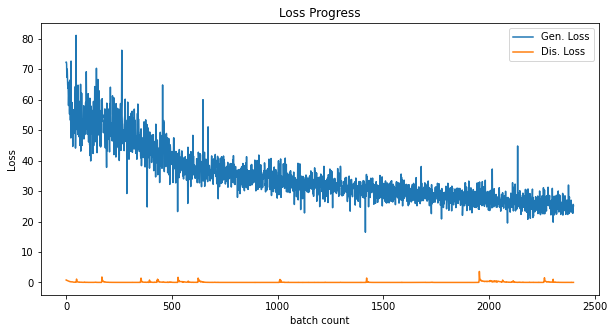

In [ ]:
# loss history 보여주기

plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 가중치 저장하기

if target == 'grayscaled':
    torch.save(model_gen.state_dict(), grayscaled_model_gen_weight_file)
    torch.save(model_dis.state_dict(), grayscaled_model_dis_weight_file)
elif target == 'styled':
    torch.save(model_gen.state_dict(), sketched_model_gen_weight_file)
    torch.save(model_dis.state_dict(), sketched_model_dis_weight_file)

# 가짜 이미지 저장 및 확인하기
---
- https://github.com/Seonghoon-Yu/AI_Paper_Review/blob/master/GAN/pix2pix(2016).ipynb

In [ ]:
import torchvision.transforms as T

In [ ]:
# 가중치 불러오기

if target == 'grayscaled':
    weights = torch.load(grayscaled_model_gen_weight_file)
elif target == 'styled':
    weights = torch.load(sketched_model_gen_weight_file)
    
model_gen.load_state_dict(weights)

In [ ]:
# 가짜 이미지 만들어내기

# evaluation model
model_gen.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for a,b in train_dl:
        fake_imgs = model_gen(a.to(device)).detach().cpu()
        origin_imgs = a
        real_imgs = b
        break

# 가짜 이미지 저장
if target == 'grayscaled':
    hifi_dir = grayscaled_hifi_dir
elif target == 'styled':
    hifi_dir = sketched_hifi_dir

for i, img in enumerate(fake_imgs):
    filename = hifi_dir + '/img' + str(i+1) + '.jpg'
    transform = T.ToPILImage()
    img = transform(img)
    img.save(filename)

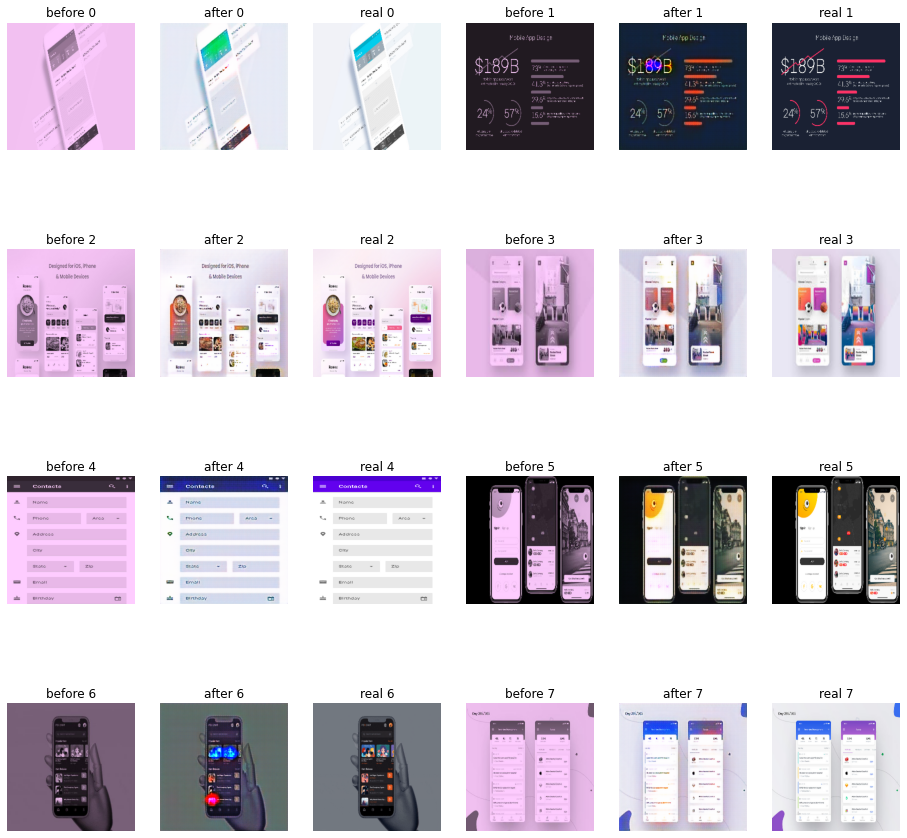

In [ ]:
# 결과 시각화하기

plt.figure(figsize=(16,16))

for i in range(0,24,3):

    plt.subplot(4,6,i+1)
    plt.imshow(to_pil_image(0.5*origin_imgs[i]+0.5))
    plt.axis('off')
    plt.title('before ' + str(i//3))

    plt.subplot(4,6,i+2)
    plt.imshow(to_pil_image(0.5*fake_imgs[i]+0.5))
    plt.axis('off')
    plt.title('after ' + str(i//3))

    plt.subplot(4,6,i+3)
    plt.imshow(to_pil_image(0.5*real_imgs[i]+0.5))
    plt.axis('off')
    plt.title('real ' + str(i//3))

# 깃허브 관련

취소 관련   
https://gmlwjd9405.github.io/2018/05/25/git-add-cancle.html

In [ ]:
cd drive/MyDrive/Colab\ Notebooks/Github/IndividualProjcet-lofiToHifi

/content/drive/MyDrive/Colab Notebooks/Github/IndividualProjcet-lofiToHifi


In [ ]:
!git config --global user.email "lightcloud98@gmail.com"
!git config --global user.name "ddophi98"

In [ ]:
!git add LoFi_To_HiFi.ipynb

In [ ]:
!git status

In [ ]:
!git commit -m "로파이를 원하는 색깔의 하이파이로 만들 수 있는지 테스트"

[main 20a5db4] 로파이를 원하는 색깔의 하이파이로 만들 수 있는지 테스트
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite LoFi_To_HiFi.ipynb (75%)


In [ ]:
!git log

In [ ]:
!git push -u origin main

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 775.79 KiB | 12.12 MiB/s, done.
Total 3 (delta 0), reused 0 (delta 0)
To https://github.com/ddophi98/IndividualProjcet-lofiToHifi.git
   38f44c1..20a5db4  main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.
